In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys

In [2]:
df = pd.read_csv('new_hps4.csv')
for index, row in df.iterrows():
    if row['state_metropolitan'] == 'metropolitan':
        df.at[index,'state_metropolitan'] = 1
    else:
        df.at[index,'state_metropolitan'] = 0
        
del df["teach_indivisualstudy"]
del df["Week"]
X = df.iloc[:,2:22]
y = df.iloc[:,-1] 


[0.03331249 0.         0.0764811  0.07675282 0.02455725 0.04743694
 0.07736006 0.07484558 0.06736175 0.06975584 0.03222041 0.16624387
 0.02097036 0.02064489 0.01748631 0.00913482 0.01715431 0.07180321
 0.08916837 0.0073096 ]


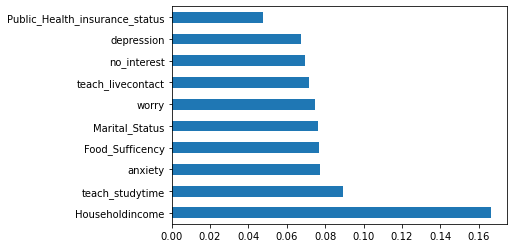

In [3]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [4]:
X = df[[ "Householdincome", "teach_studytime", "teach_livecontact", "anxiety", "worry", "Marital_Status", "Food_Sufficency", "no_interest","depression","Public_Health_insurance_status"]].to_numpy()
y = df[['whether_study']].to_numpy()
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree_train_list = []
index = []
tree_test_list = []
for i in range(100):
    index.append(i+ 1)
    tree = DecisionTreeClassifier(max_depth=i + 1)
    tree.fit(X_train, y_train)
    tree_test_list.append(tree.score(X_test, y_test)) 
    tree_train_list.append(tree.score(X_train, y_train)) 

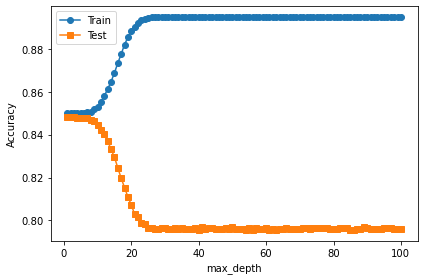

In [6]:
plt.plot(index, tree_train_list, marker='o', label='Train')
plt.plot(index, tree_test_list, marker='s', label='Test')
plt.legend(loc='best', numpoints=1)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.tight_layout()

In [7]:
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier(random_state=123)

new_list = [None]
for i in range(20):
    new_list.append(i+1)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': new_list
}

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 85.01%
Best Params: {'criterion': 'gini', 'max_depth': 5}
Test Accuracy: 84.79%


In [12]:
y_pred_tree = gs.best_estimator_.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
tree_conf = confusion_matrix(y_test, y_pred_tree)
print(tree_conf)
print(classification_report(y_test, y_pred_tree))


[[    6  8601]
 [   14 48010]]
              precision    recall  f1-score   support

           0       0.30      0.00      0.00      8607
           1       0.85      1.00      0.92     48024

    accuracy                           0.85     56631
   macro avg       0.57      0.50      0.46     56631
weighted avg       0.76      0.85      0.78     56631



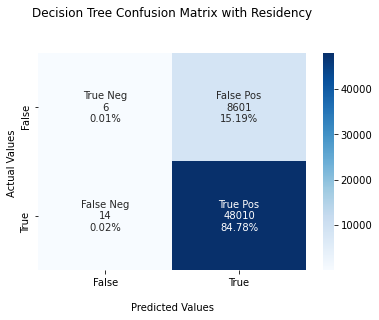

In [19]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
tree_conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
tree_conf.flatten()/np.sum(tree_conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(tree_conf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Decision Tree Confusion Matrix with Residency\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression

log_res = LogisticRegression(random_state=123, C = 0.001)

log_res.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
y_pred = log_res.predict(X_test)
print(mean_squared_error(y_test, y_pred))

print('Test Accuracy: %.2f%%' % (log_res.score(X_test, y_test)*100))

0.1519838957461461
Test Accuracy: 84.80%


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=123)

param_grid_forest = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10, 20, 50, 100, 150],
    'max_depth': [1, 10, 50, 100, 150]
}

gs_forest = GridSearchCV(estimator=forest,
                  param_grid=param_grid_forest,
                  scoring='accuracy',
                  cv=10)

gs_forest.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs_forest.best_score_*100))
print('Best Params: %s' % gs_forest.best_params_)
print('Test Accuracy: %.2f%%' % (gs_forest.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 85.01%
Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Test Accuracy: 84.80%


In [16]:
y_pred_tree_1 = gs_forest.best_estimator_.predict(X_test)

tree_conf_1 = confusion_matrix(y_test, y_pred_tree_1)
print(tree_conf_1)
print(classification_report(y_test, y_pred_tree_1))


[[   16  8591]
 [   19 48005]]
              precision    recall  f1-score   support

           0       0.46      0.00      0.00      8607
           1       0.85      1.00      0.92     48024

    accuracy                           0.85     56631
   macro avg       0.65      0.50      0.46     56631
weighted avg       0.79      0.85      0.78     56631



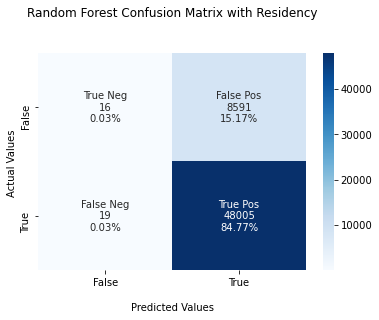

In [21]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
tree_conf_1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
tree_conf_1.flatten()/np.sum(tree_conf_1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(tree_conf_1, annot=labels, fmt='', cmap='Blues')
ax.set_title('Random Forest Confusion Matrix with Residency\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [14]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train)
nb=nb.score(X_test,y_test)

print('Test Accuracy: %.2f%%' % (nb*100))

Test Accuracy: 82.04%
